# Download Dataset
---

In [1]:
!wget -O dataset.zip "https://drive.usercontent.google.com/download?id=1Szc920DAh5kU8Qk38Doq0znEVR1QmTZS&export=download&confirm=t"

--2025-04-13 19:45:28--  https://drive.usercontent.google.com/download?id=1Szc920DAh5kU8Qk38Doq0znEVR1QmTZS&export=download&confirm=t
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.200.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5036072833 (4.7G) [application/octet-stream]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   4.69G  57.2MB/s    in 95s     

2025-04-13 19:47:05 (50.7 MB/s) - ‘dataset.zip’ saved [5036072833/5036072833]



In [2]:
!unzip dataset.zip &> /dev/null

In [3]:
!cp -r "/content/OD-WeaponDetection-master/Weapons and similar handled objects/Sohas_weapon-Classification" ./dataset

In [4]:
!mv dataset/monedero/ dataset/wallet/
!mv dataset/tarjeta/ dataset/card/
!mv dataset/billete/ dataset/cash/

In [5]:
!cp -r dataset dataset_binary

!mkdir dataset_binary/safe
!mkdir dataset_binary/unsafe

!mv dataset_binary/wallet/* dataset_binary/safe
!mv dataset_binary/card/* dataset_binary/safe
!mv dataset_binary/cash/* dataset_binary/safe
!mv dataset_binary/smartphone/* dataset_binary/safe

!mv dataset_binary/knife/* dataset_binary/unsafe
!mv dataset_binary/pistol/* dataset_binary/unsafe

!rm -rf dataset_binary/knife
!rm -rf dataset_binary/pistol
!rm -rf dataset_binary/smartphone
!rm -rf dataset_binary/cash
!rm -rf dataset_binary/card
!rm -rf dataset_binary/wallet

In [6]:
!cp OD-WeaponDetection-master/Knife_detection/Images/* dataset_binary/unsafe
!cp OD-WeaponDetection-master/Pistol\ detection/Weapons/* dataset_binary/unsafe/

---
# Install Python packages

In [71]:
!pip install torch torchvision matplotlib numpy opencv-python &> /dev/null

---
# Imports

In [72]:
from torchvision.datasets import ImageFolder
import torchvision.ops as ops
from torchvision import transforms
from torch import nn, Tensor
import torch

In [73]:
from google.colab.patches import cv2_imshow
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import PIL
import cv2
import os
import time
import requests

---
# Preview dataset

In [74]:
!for folder in dataset/*; do echo ${folder} - $(ls $folder | wc -l) images; done

dataset/card - 446 images
dataset/cash - 777 images
dataset/knife - 2349 images
dataset/pistol - 3975 images
dataset/smartphone - 1184 images
dataset/wallet - 813 images


In [75]:
!for folder in dataset_binary/*; do echo ${folder} - $(ls $folder | wc -l) images; done

dataset_binary/safe - 3220 images
dataset_binary/unsafe - 11402 images


In [77]:
IMG_SIZE = 128
MODEL_CHECKPOINT = None
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
full_dataset = ImageFolder(root='dataset_binary', transform=transform)
full_dataset

Dataset ImageFolder
    Number of datapoints: 14622
    Root location: dataset_binary
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

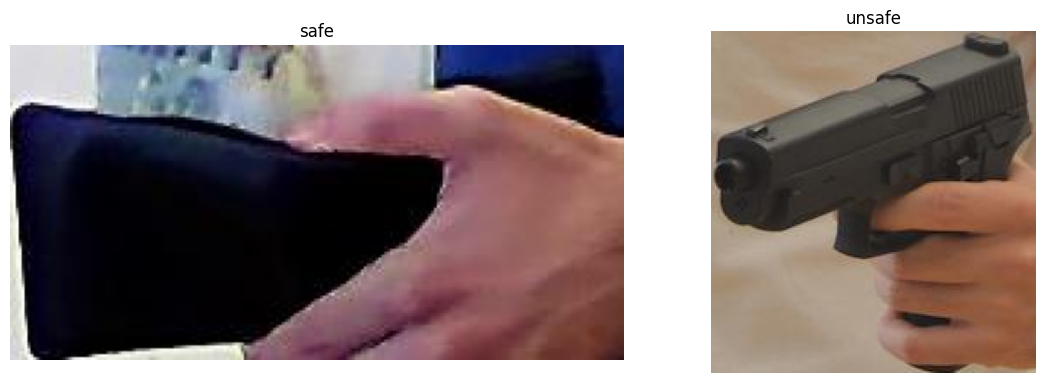

In [78]:
classes_to_show = {
    value: key
    for key, value in full_dataset.class_to_idx.items()
}

i = 0

fig, axes = plt.subplots(1, len(classes_to_show), figsize=(12, 4))
while classes_to_show:
    img, label = full_dataset.samples[i]
    if label not in classes_to_show:
        i += 1
        continue
    axes[label].imshow(plt.imread(img))
    plt.tight_layout()
    axes[label].axis('off')
    axes[label].grid(False)
    axes[label].set_title(classes_to_show[label])

    i += 1
    if i >= len(full_dataset):
        break
    del classes_to_show[label]

plt.show()

del i
del classes_to_show

In [79]:
train_size = int(len(full_dataset) * 0.80)
remaining_size = len(full_dataset) - train_size
test_size = 25
eval_size = remaining_size - test_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, remaining_size])
test_dataset, eval_dataset = torch.utils.data.random_split(test_dataset, [test_size, eval_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

print('Train:', train_size)
print('Eval:', eval_size)
print('Test:', test_size)

Train: 11697
Eval: 2900
Test: 25


---
# Setup CNN layers

In [80]:
class SharpItemDetection(nn.Module):
    layers: nn.Sequential

    def __init__(self):
        super().__init__()

        output_size = (IMG_SIZE // 2 // 2)
        feature_count = 16

        self.layers = nn.Sequential(
            # RGBA > Grayscale (INxINx3 > INxINx1)
            nn.Conv2d(
                in_channels=3,
                out_channels=1,
                kernel_size=1,
            ),
            # Get features (INxINx1 > INxINx16)
            nn.Conv2d(
                in_channels=1,
                out_channels=feature_count,
                kernel_size=3,
                padding=1,
            ),
            # Remove negative values (INxINx16 > INxINx16)
            nn.ReLU(),
            # Downsample (INxINx16 > (IN/2)x(IN/2)x16)
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),
            # Get features #2 ((IN/2)x(IN/2)x16 > (IN/2)x(IN/2)x32)
            nn.Conv2d(
                in_channels=16,
                out_channels=feature_count*2,
                kernel_size=3,
                padding=1,
            ),
            # Remove negative values #2 ((IN/2)x(IN/2)x32 > (IN/2)x(IN/2)x32)
            nn.ReLU(),
            # Downsample #2 ((IN/2)x(IN/2)x32 > (IN/2/2)x(IN/2/2)x32)
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),
            # # Get features #3 ((IN/2/2)x(IN/2/2)x16 > (IN/2/2)x(IN/2/2)x32)
            # nn.Conv2d(
            #     in_channels=feature_count*2,
            #     out_channels=feature_count*2*2,
            #     kernel_size=3,
            #     padding=1,
            # ),
            # # Remove negative values #3 ((IN/2/2)x(IN/2/2)x32 > (IN/2/2)x(IN/2/2)x32)
            # nn.ReLU(),
            # # Downsample #3 ((IN/2/2)x(IN/2/2)x32 > (IN/2/2/2)x(IN/2/2/2)x32)
            # nn.MaxPool2d(
            #     kernel_size=2,
            #     stride=2,
            # ),
            # Flatten for linear
            nn.Flatten(),
            # Multiply features with weights + bias
            nn.Linear(
                in_features=output_size * output_size * feature_count*2,
                out_features=1,
            ),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.layers(x)

---
# Train

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [82]:
model = SharpItemDetection().to(device)
model

SharpItemDetection(
  (layers): Sequential(
    (0): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=32768, out_features=1, bias=True)
  )
)

In [83]:
MODEL_CHECKPOINT = None

# Step 5: Define the loss function (BCEWithLogitsLoss)
criterion = nn.BCEWithLogitsLoss()

# Step 6: Define the optimizer (Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss for the epoch
    print(
        f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}"
    )

# Save the model + timestamp
timestamp = time.strftime("%Y-%m-%d_%H-%M-%S")
MODEL_CHECKPOINT = f'model_{timestamp}_{IMG_SIZE}.pt'
torch.save(model.state_dict(), MODEL_CHECKPOINT)

Epoch [1/10], Loss: 0.3929
Epoch [2/10], Loss: 0.2849
Epoch [3/10], Loss: 0.2314
Epoch [4/10], Loss: 0.1987
Epoch [5/10], Loss: 0.1712
Epoch [6/10], Loss: 0.1451
Epoch [7/10], Loss: 0.1213
Epoch [8/10], Loss: 0.0971
Epoch [9/10], Loss: 0.0788
Epoch [10/10], Loss: 0.0666


---
# Evaluation

In [26]:
if MODEL_CHECKPOINT is None:
    MODEL_CHECKPOINT = './model_2025-04-13_01-23-42_128 (1).pt'

In [84]:
# Load saved model checkpoint from 'model.pt'
model.load_state_dict(torch.load(MODEL_CHECKPOINT))

<All keys matched successfully>

In [85]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation for testing
    for images, labels in eval_loader:
        images, labels = images.to(device), labels.to(device).float()

        # Forward pass
        outputs = model(images)

        # Apply sigmoid to get probabilities
        predicted_probs = torch.sigmoid(outputs).squeeze()

        # Convert probabilities to binary predictions (0 or 1)
        predicted_labels = (predicted_probs > 0.5).float()

        # Calculate accuracy
        correct += (predicted_labels == labels).sum().item()
        total += labels.size(0)

# Calculate and print accuracy
accuracy = correct / total
print(f"Eval Accuracy: {accuracy * 100:.2f}%")


Eval Accuracy: 91.55%


---
# Tests

## Using remaining images of dataset

In [86]:
# Use this for OpenCV-loaded images
def detect_objects_batch(
    model: SharpItemDetection,
    image,
    tile_size=IMG_SIZE,
    stride=64,
    scales=[1.0, 0.75, 0.5],
    threshold=0.5,
    batch_size=64
):
    detect_transform = transforms.Compose([
        transforms.Lambda(lambda img: PIL.Image.fromarray(img)),  # Converts NumPy to PIL
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])

    model.eval()
    h, w, _ = image.shape
    all_tiles = []
    tile_info = []

    for y in range(0, h - tile_size + 1, stride):
        for x in range(0, w - tile_size + 1, stride):
            tile = image[y:y + tile_size, x:x + tile_size]

            for scale in sorted(scales):
                scaled_tile = cv2.resize(tile, (0, 0), fx=scale, fy=scale)
                resized_tile = cv2.resize(scaled_tile, (tile_size, tile_size))

                tile_tensor = detect_transform(resized_tile)
                all_tiles.append(tile_tensor)
                tile_info.append((x, y, scale))

    boxes = []

    with torch.no_grad():
        for i in range(0, len(all_tiles), batch_size):
            batch = torch.stack(all_tiles[i:i+batch_size]).to(device)
            outputs = model(batch)
            probs = torch.sigmoid(outputs).squeeze().cpu().numpy()

            for j, prob in enumerate(probs):
                if prob > threshold:
                    x, y, scale = tile_info[i + j]
                    box_w = int(tile_size / scale)
                    box_h = int(tile_size / scale)
                    boxes.append((x, y, x + box_w, y + box_h))

    return boxes


def show_boxes(image, boxes, figsize=(12, 12), title="Detected Objects"):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    for (x1, y1, x2, y2) in boxes:
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)

    plt.title(title)
    plt.axis('off')
    plt.show()


def apply_nms(boxes, iou_threshold=0.3):
    if len(boxes) == 0:
        return []

    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores = torch.ones((boxes_tensor.shape[0],))  # uniform confidence

    keep = ops.nms(boxes_tensor, scores, iou_threshold)
    return boxes_tensor[keep].int().tolist()


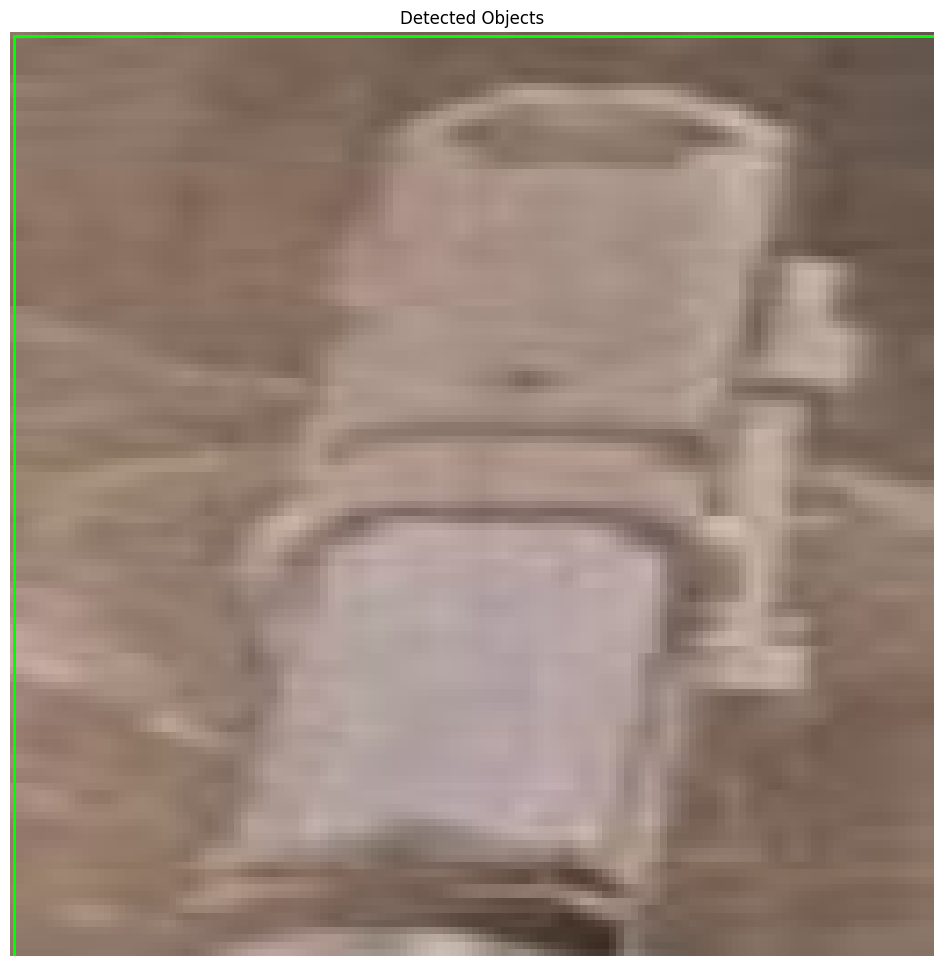

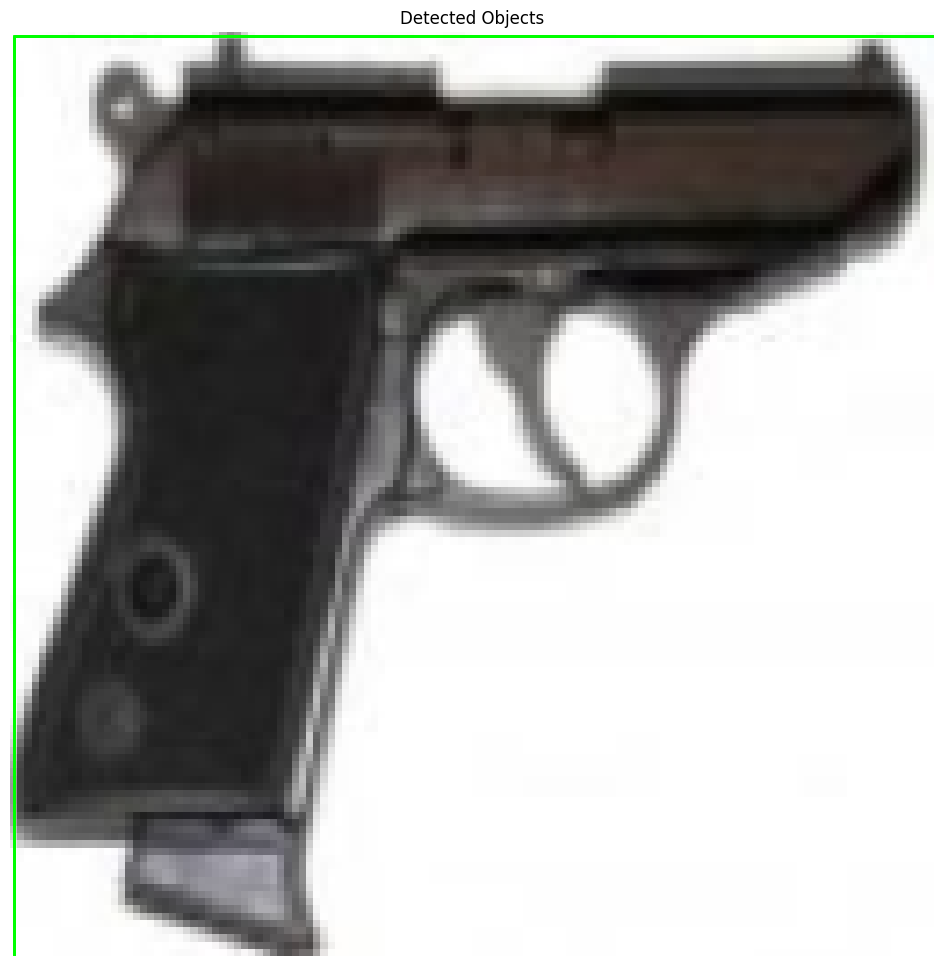

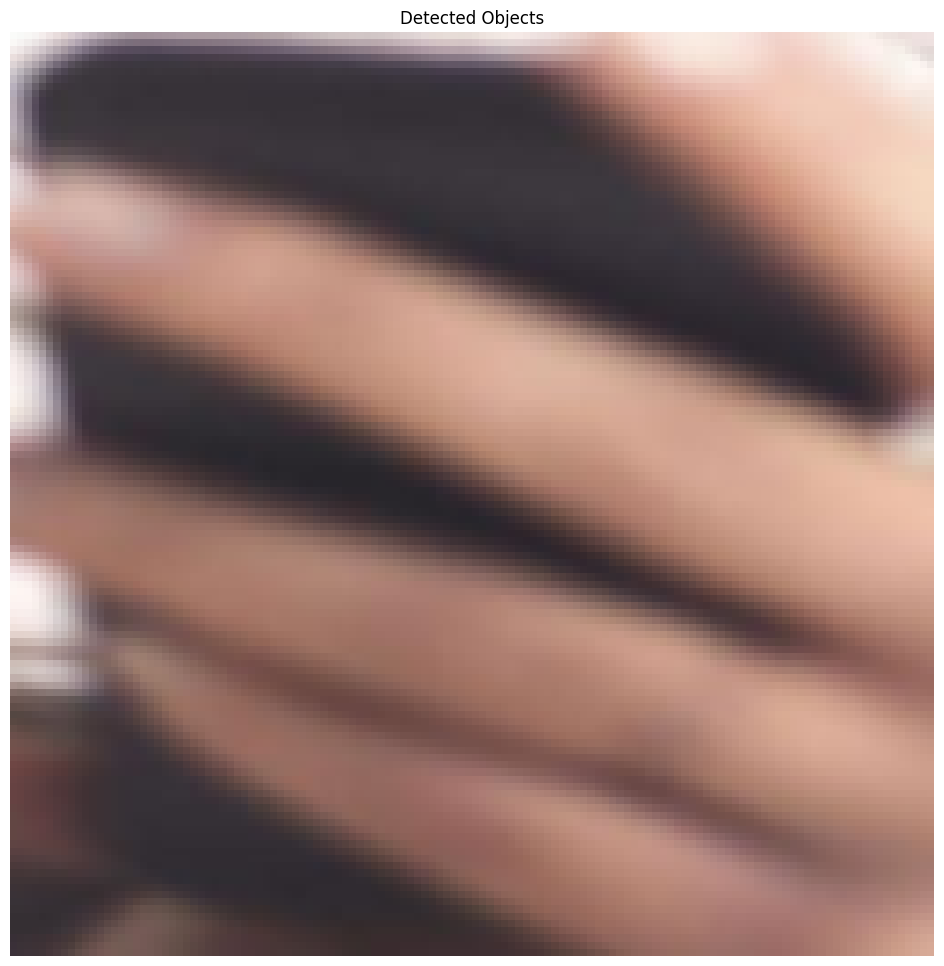

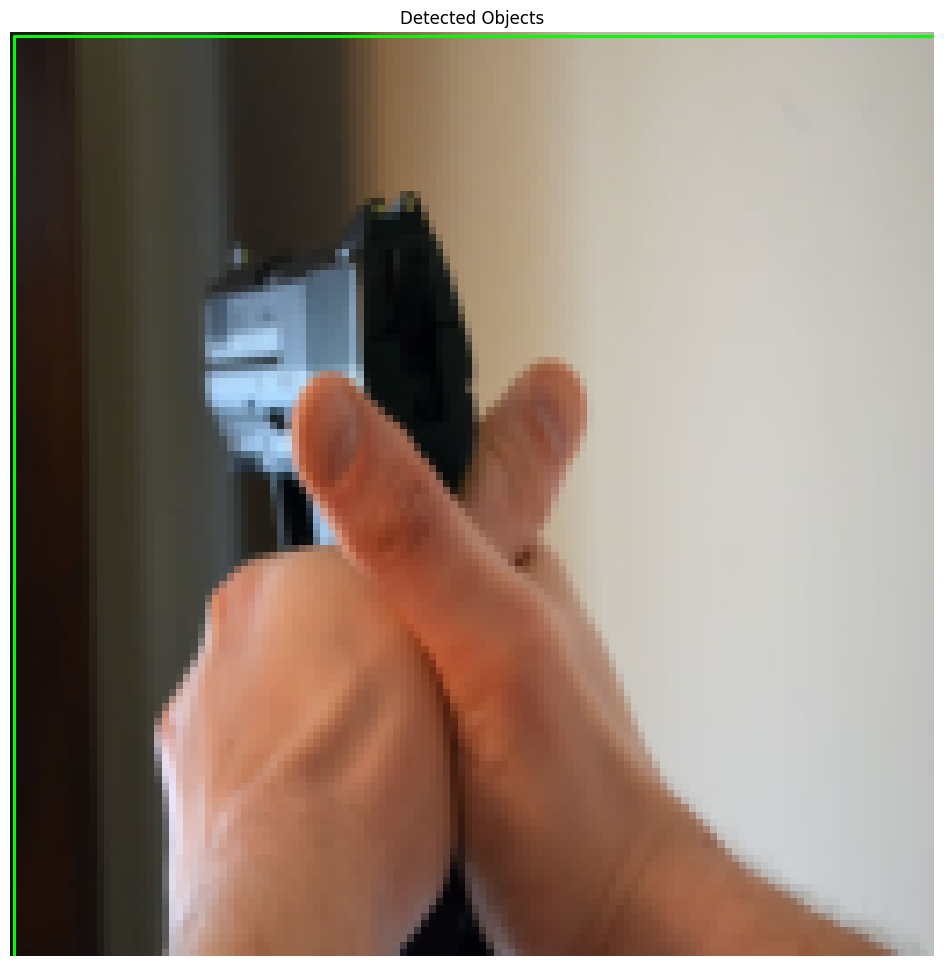

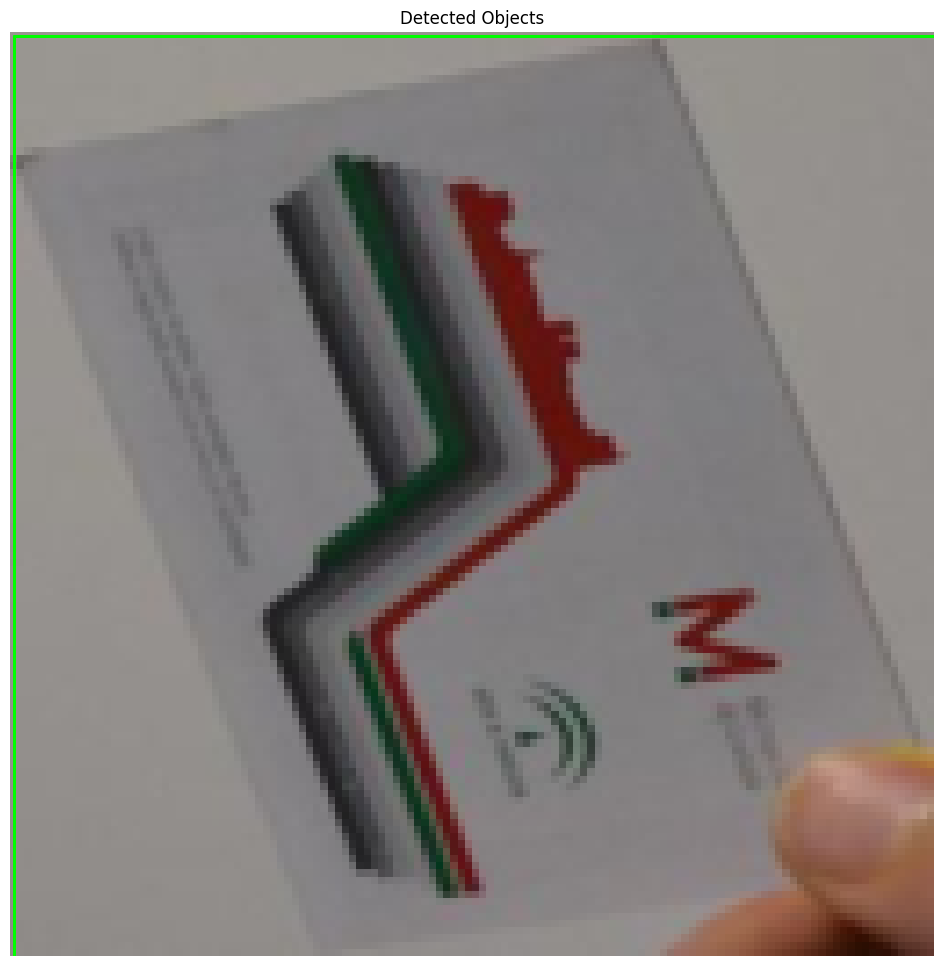

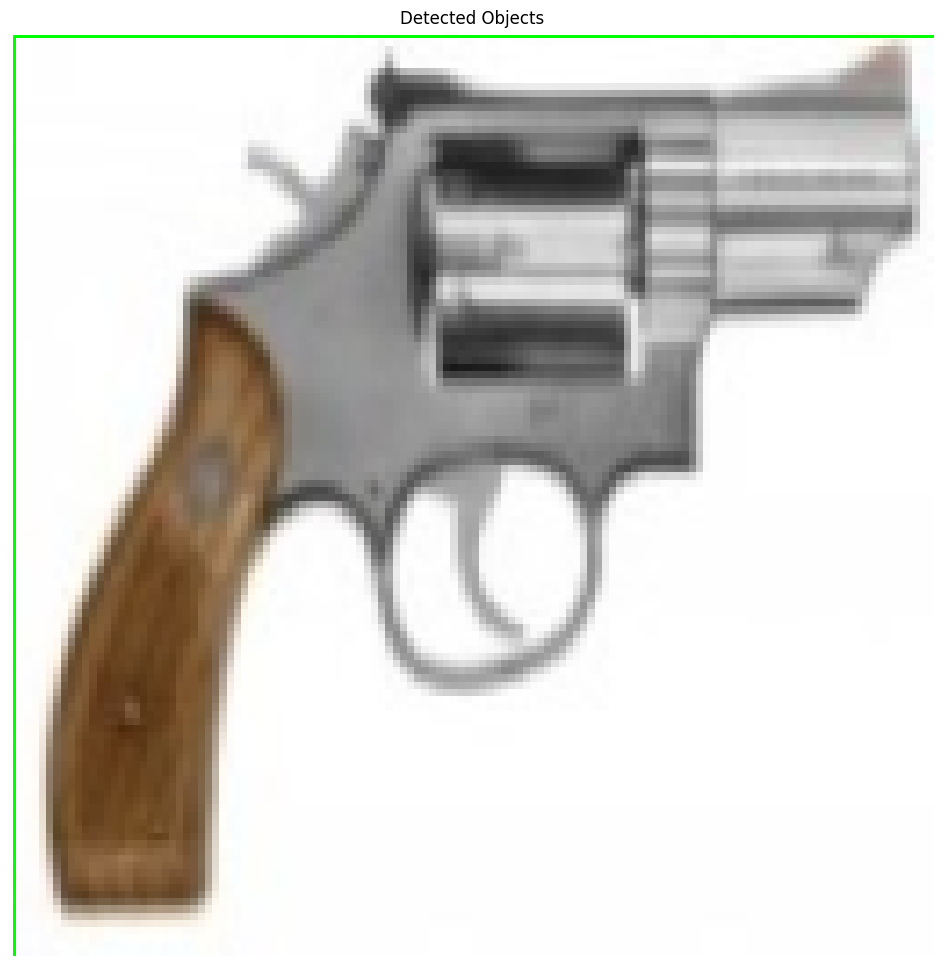

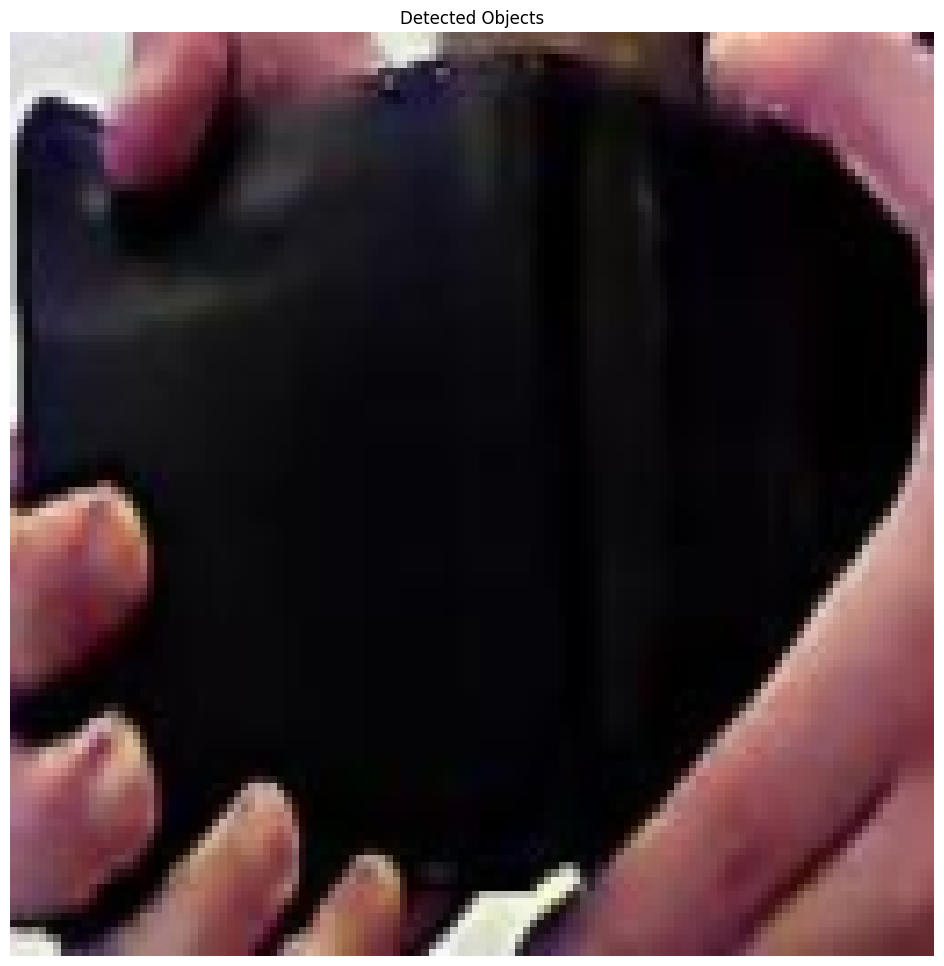

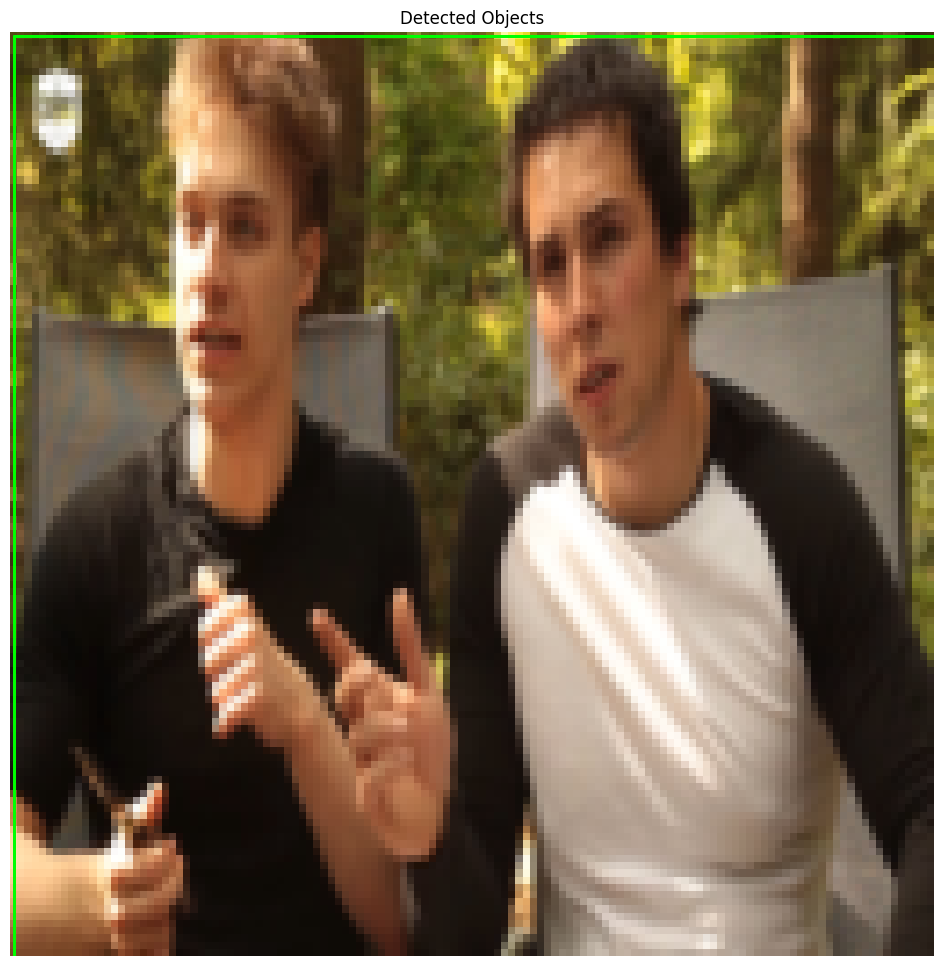

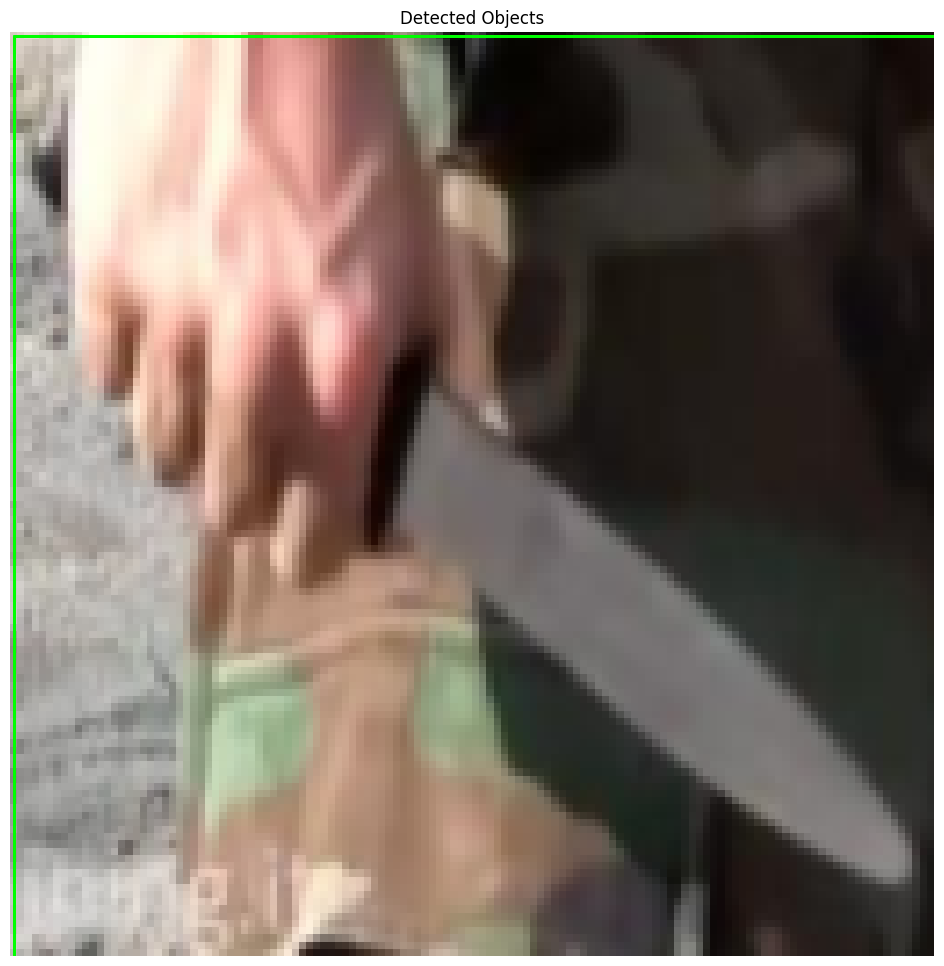

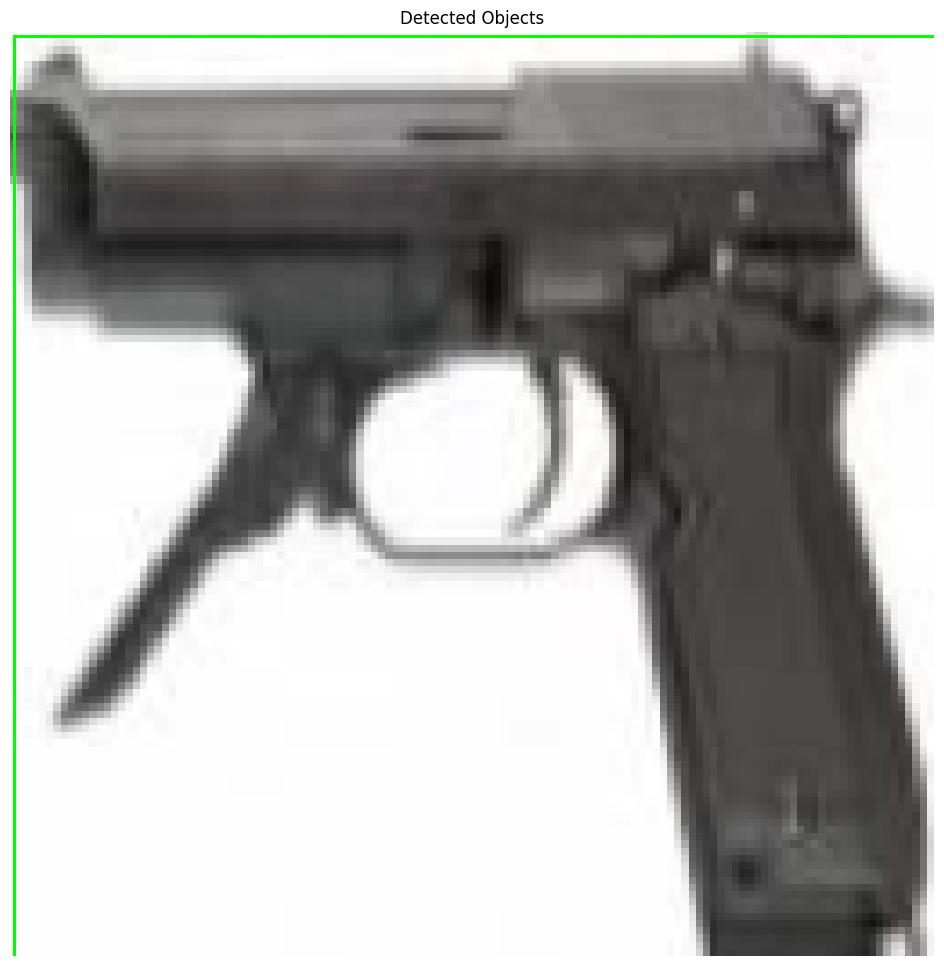

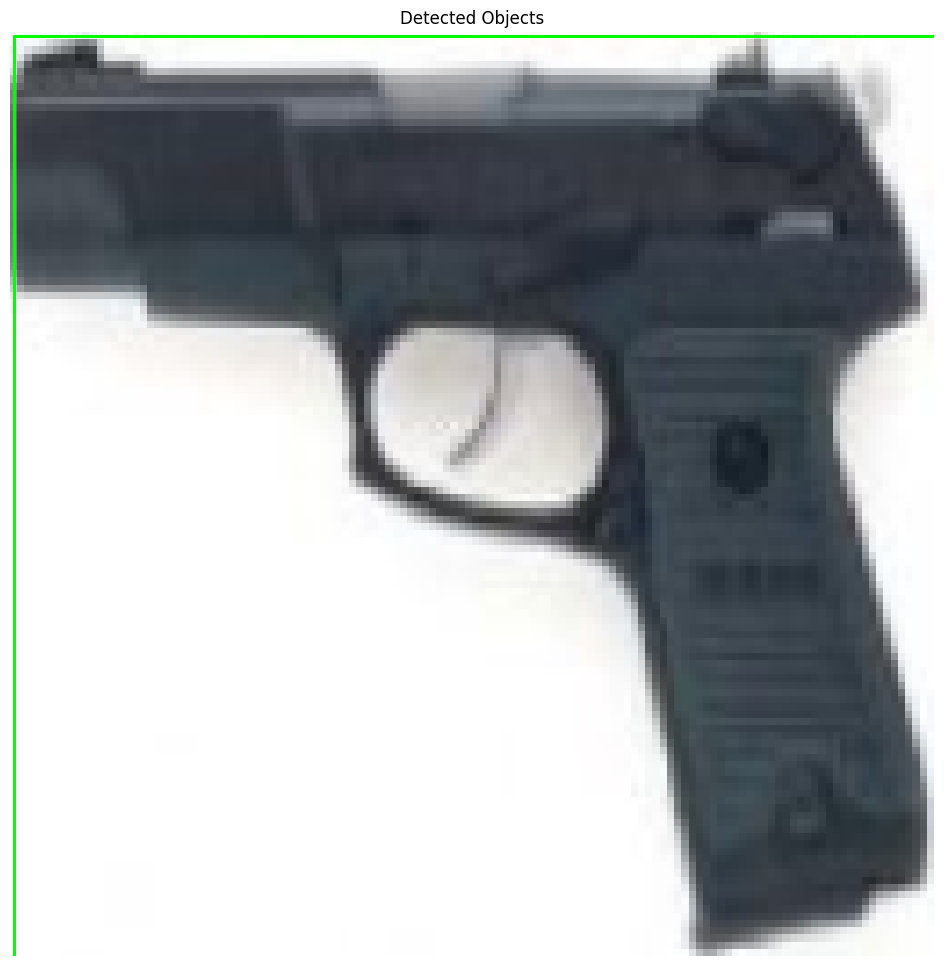

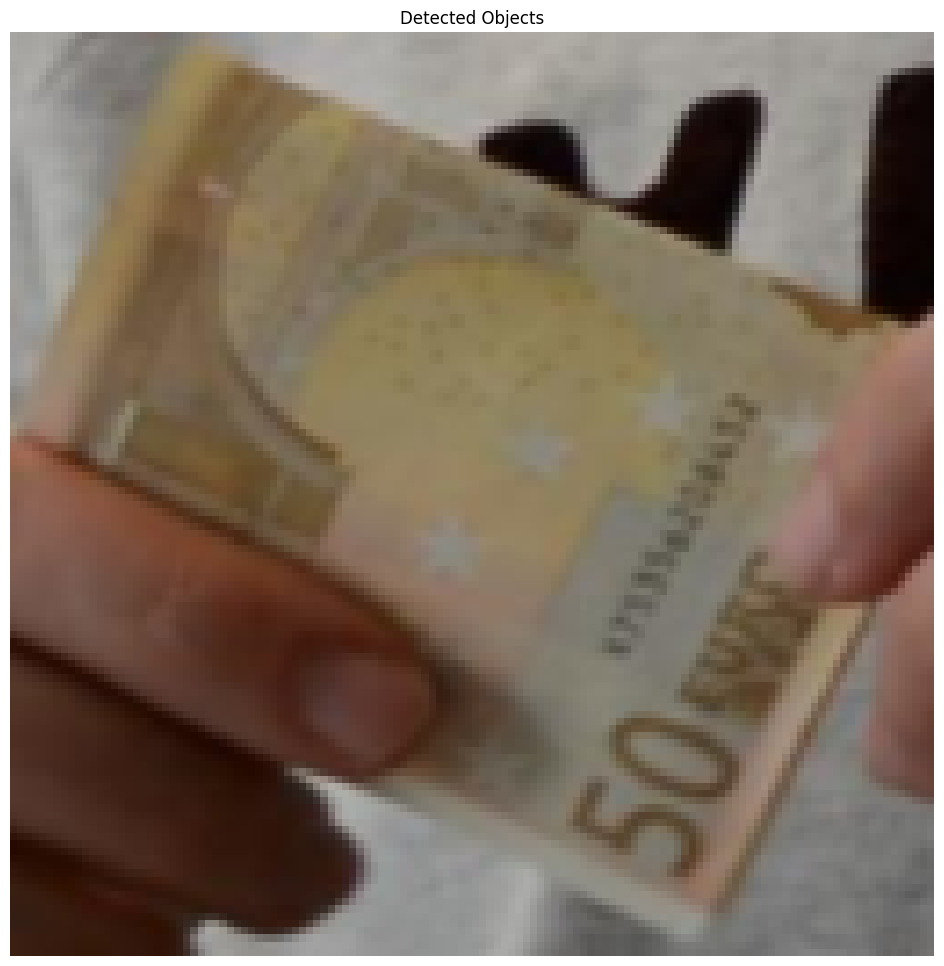

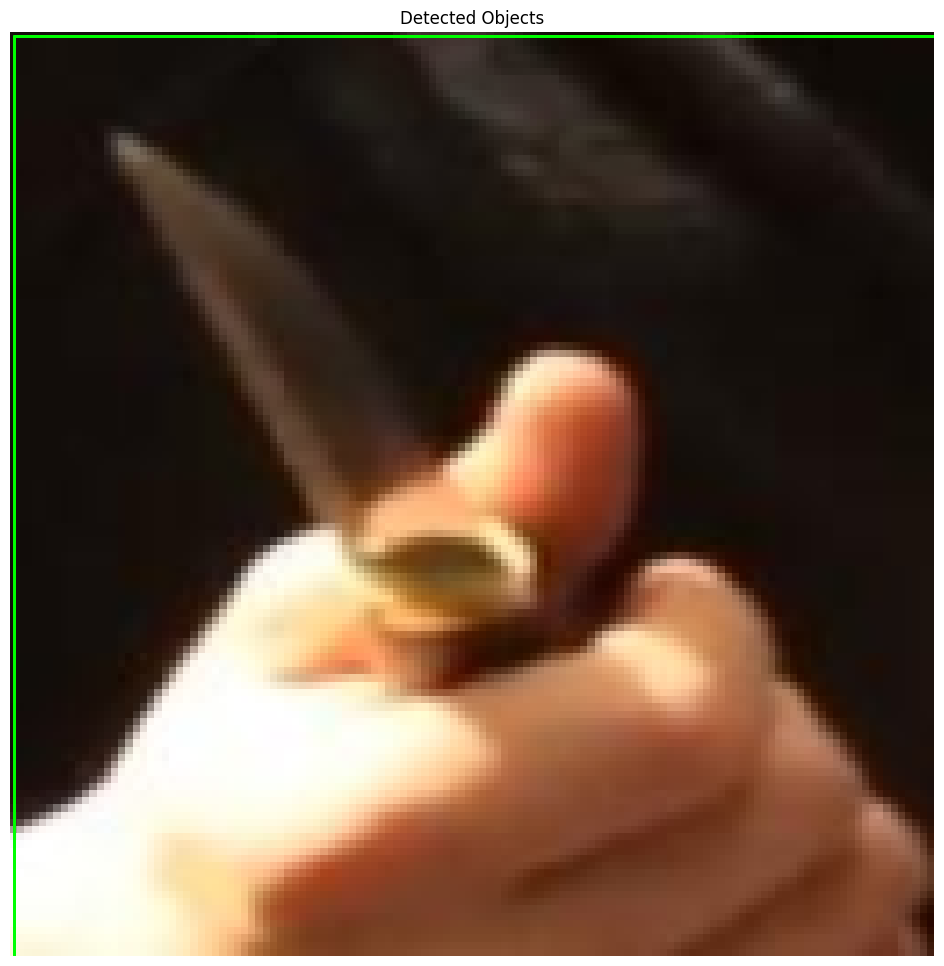

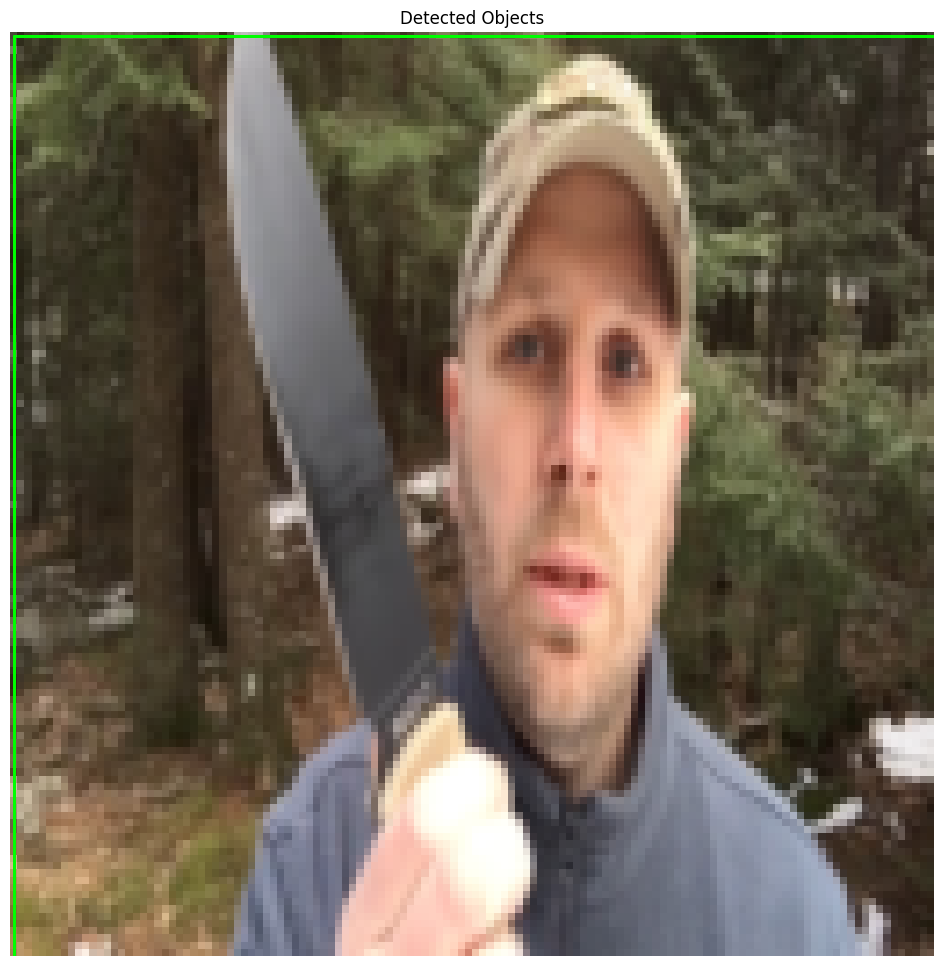

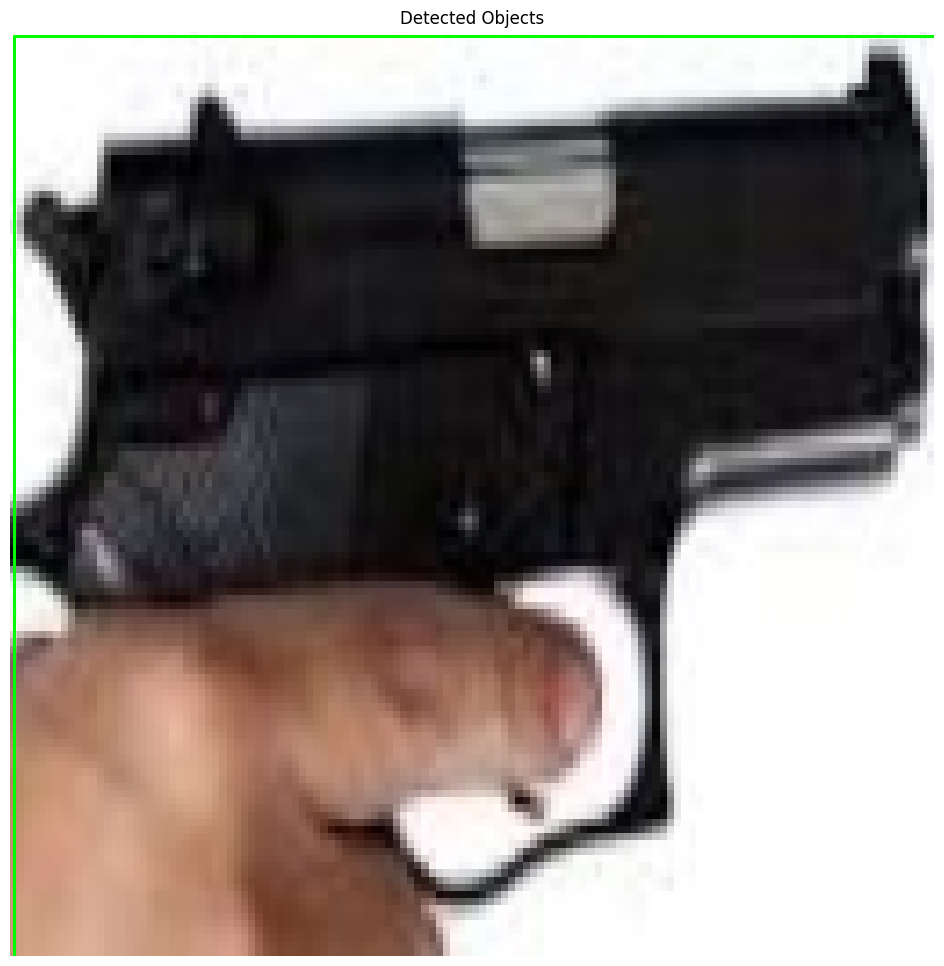

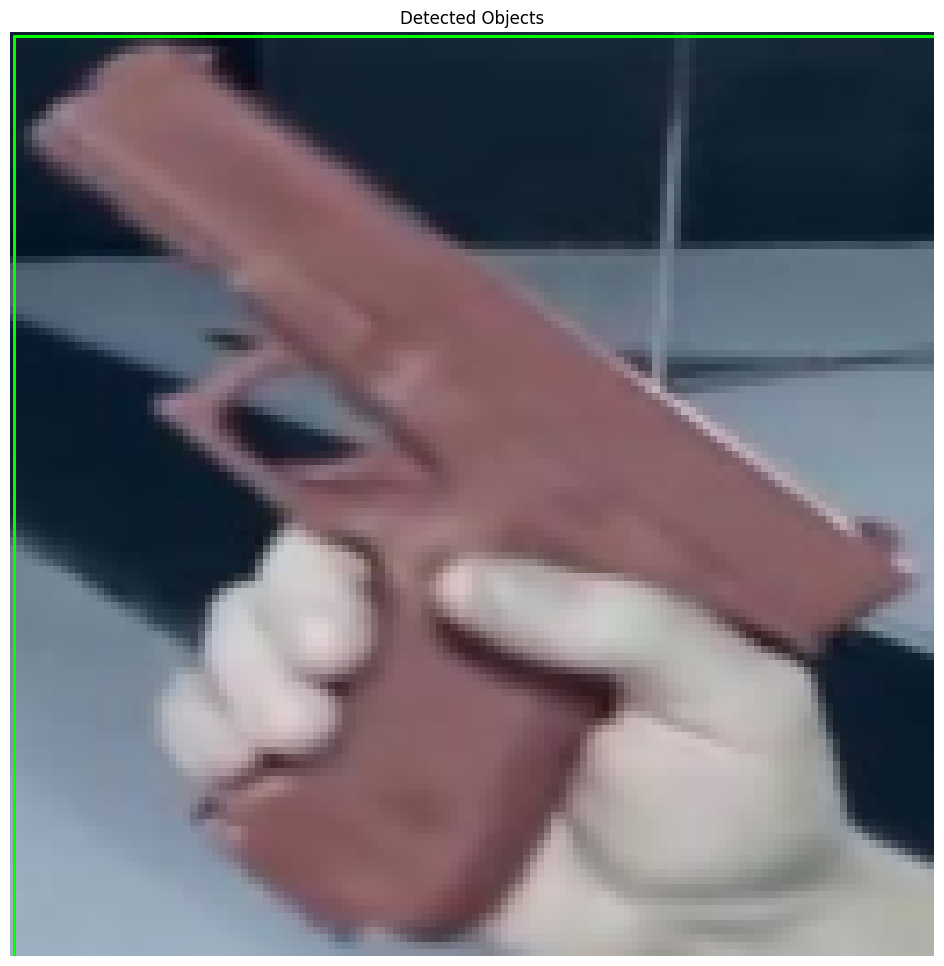

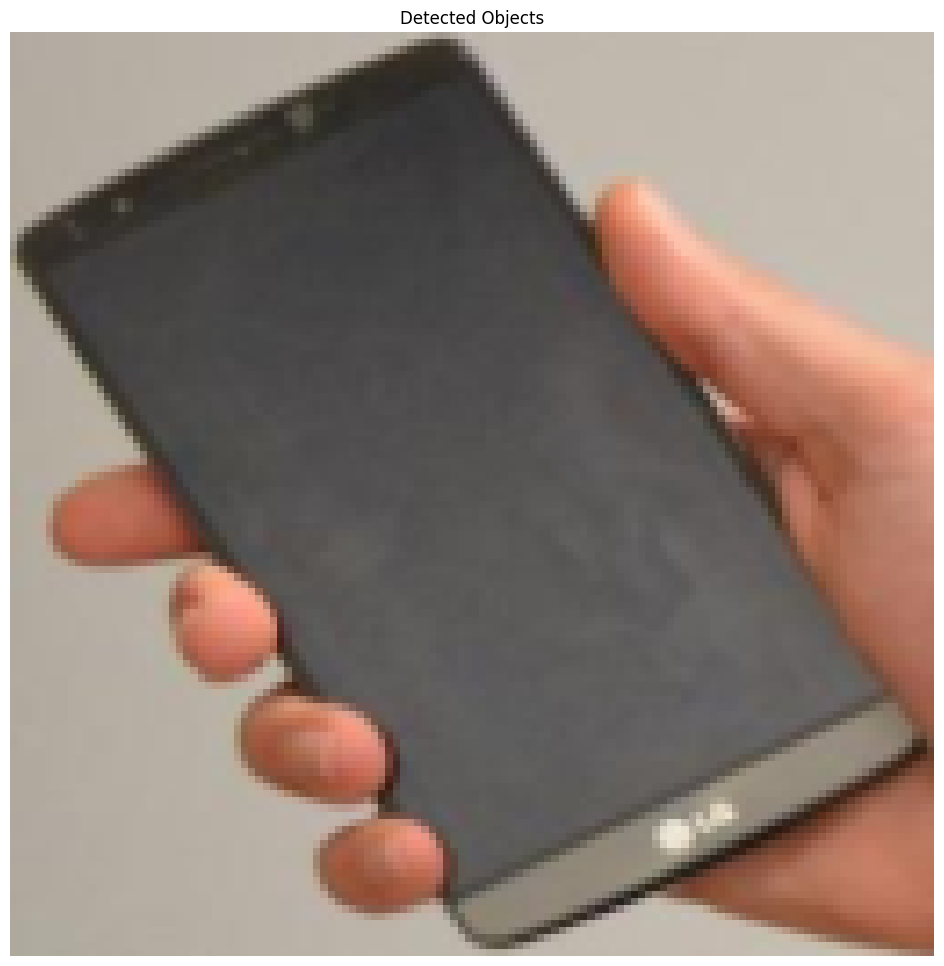

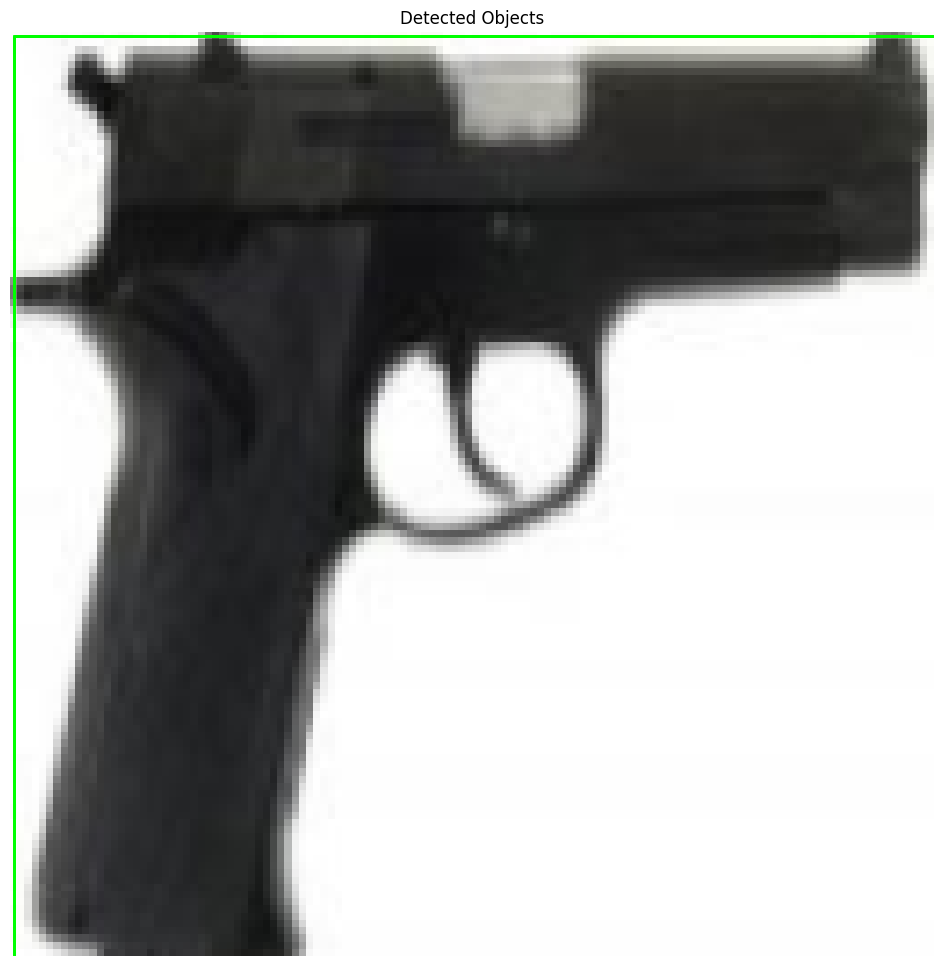

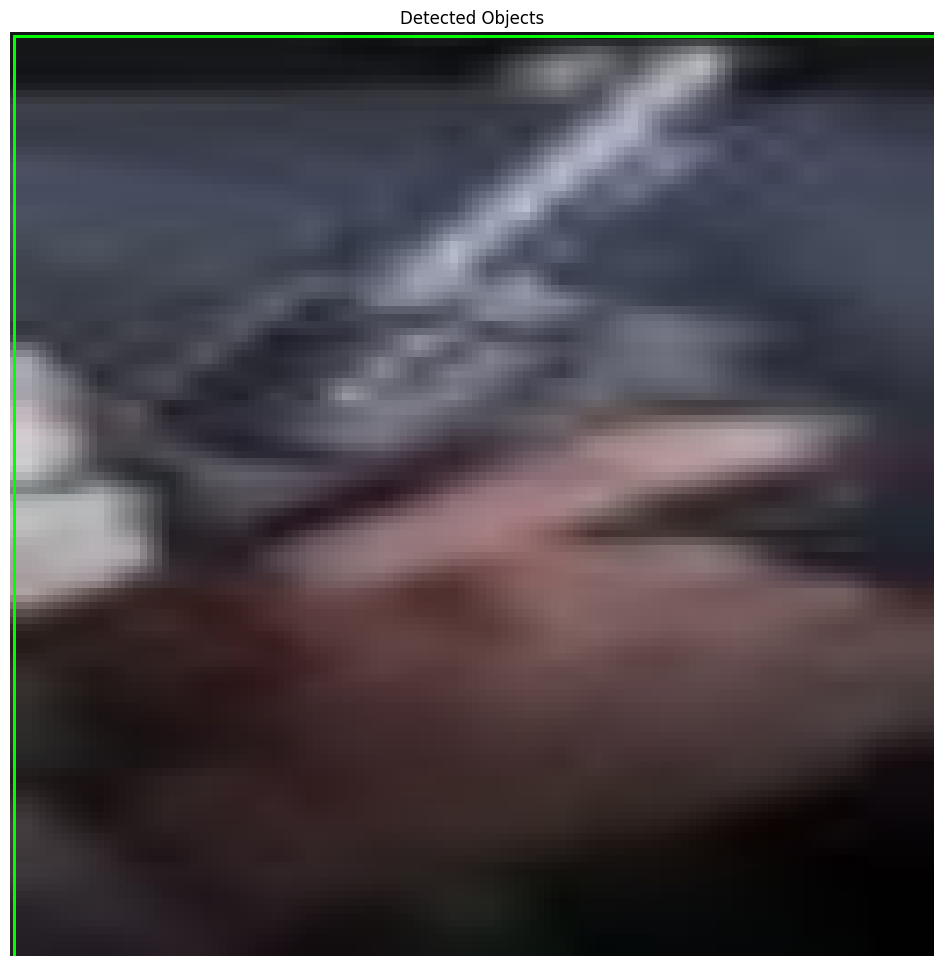

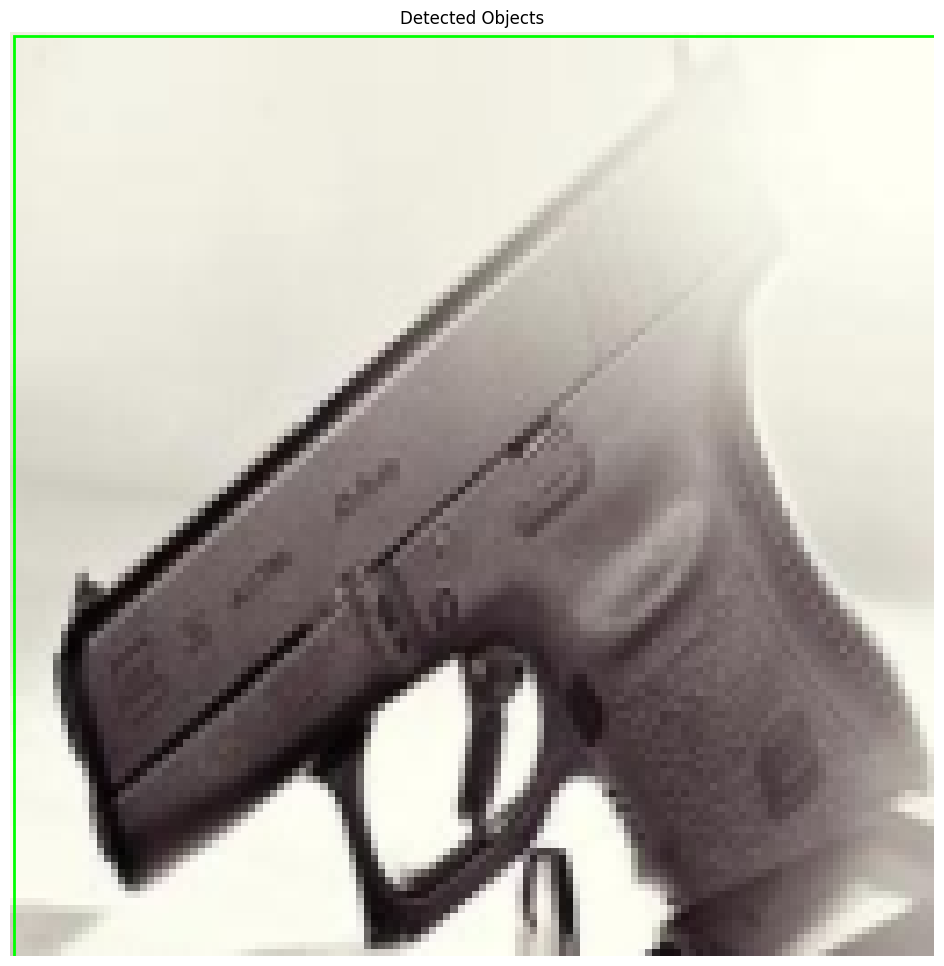

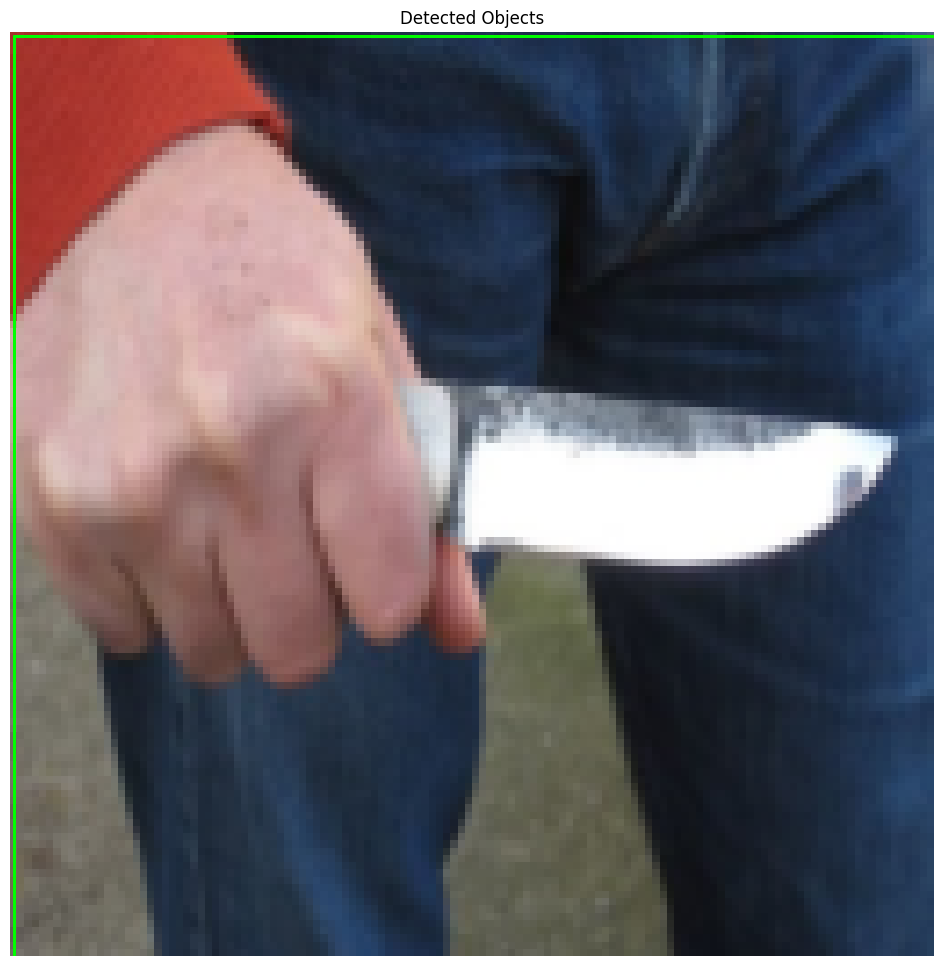

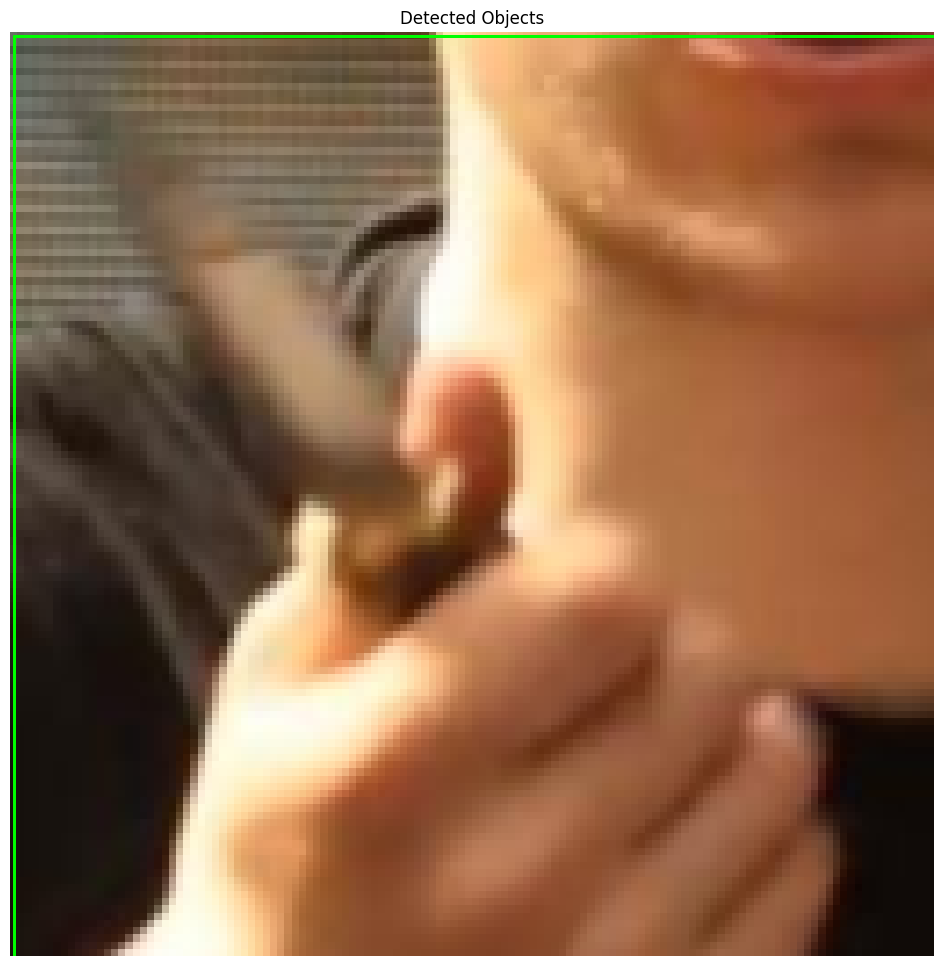

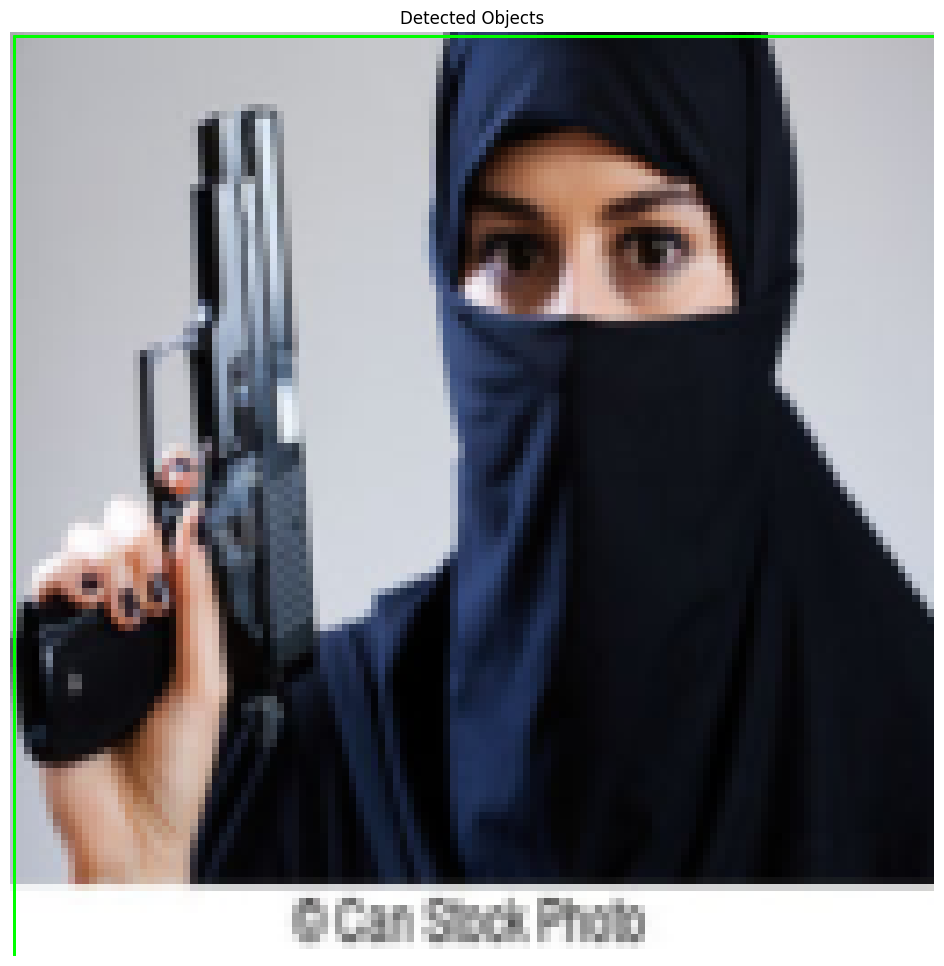

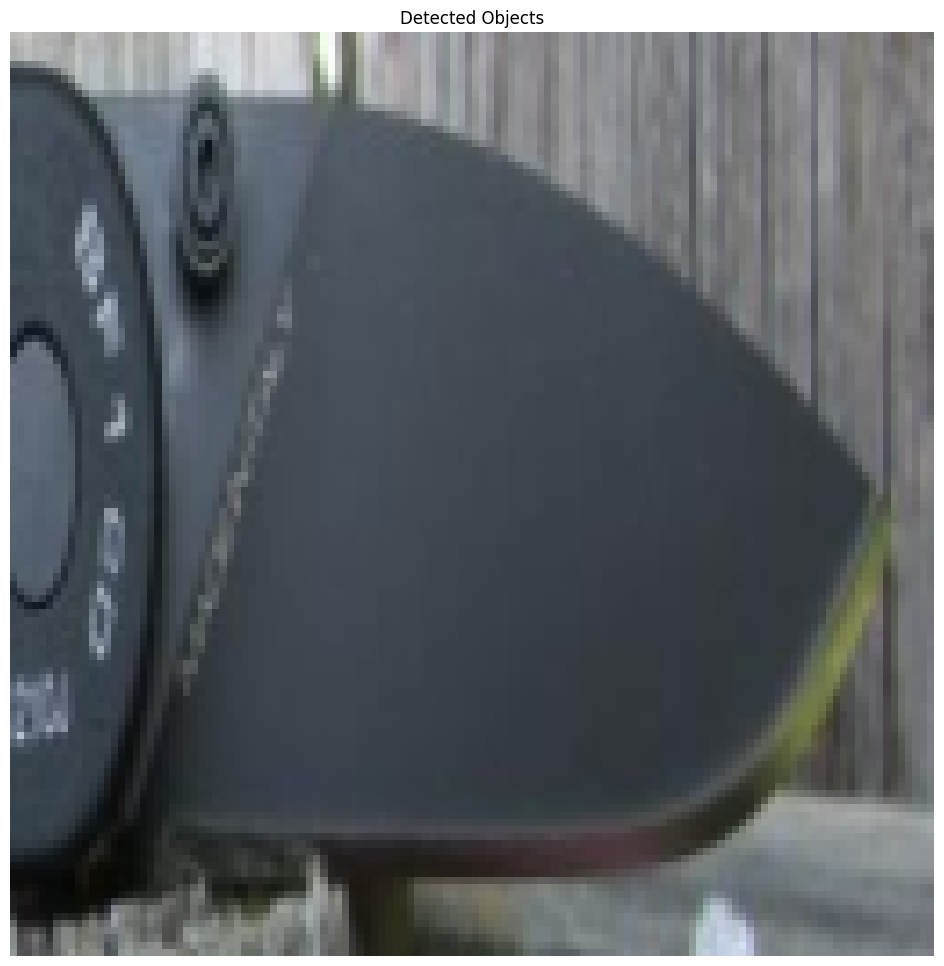

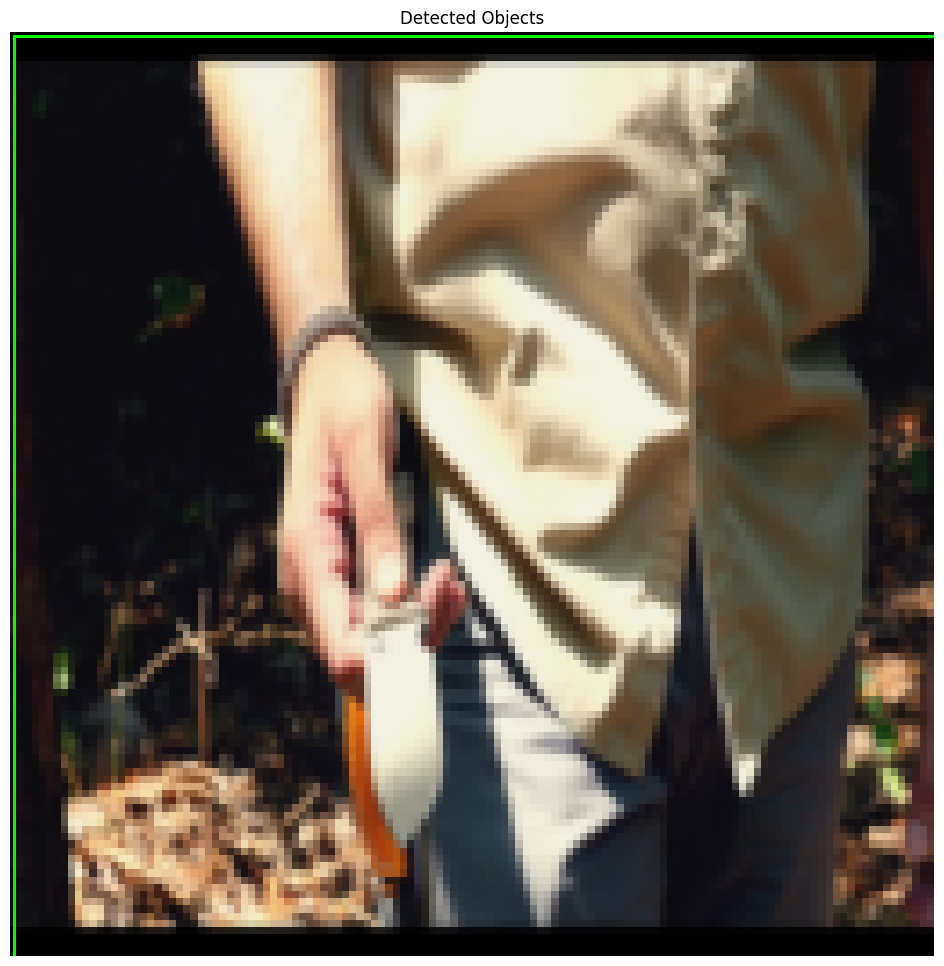

In [87]:
# Test using test_loader using detect_objects_batch and show_boxes
for _images, _labels in test_loader:
    for i in range(len(_images)):
        img = _images[i].permute(1, 2, 0).numpy()
        img = (img * 255).astype(np.uint8)
        # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        model = SharpItemDetection().to(device)
        model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location=device))
        boxes = detect_objects_batch(model, img, threshold=0.5)
        show_boxes(img, boxes)


## Using provided videos

In [20]:
# Download videos
!wget -O video_1.mp4 "https://drive.usercontent.google.com/download?id=1AV6y7OFPgq9UiU0TMUjoaoYQHsvKO__u&export=download&confirm=t"
!wget -O video_2.mp4 "https://drive.usercontent.google.com/download?id=1XBhBKY9QHo0xj8gXMYcq92e-vrECrNH3&export=download&confirm=t"

--2025-04-13 19:50:20--  https://drive.usercontent.google.com/download?id=1AV6y7OFPgq9UiU0TMUjoaoYQHsvKO__u&export=download&confirm=t
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.200.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63930697 (61M) [video/mp4]
Saving to: ‘video_1.mp4’

video_1.mp4         100%[===================>]  60.97M  69.5MB/s    in 0.9s    

2025-04-13 19:50:28 (69.5 MB/s) - ‘video_1.mp4’ saved [63930697/63930697]

--2025-04-13 19:50:28--  https://drive.usercontent.google.com/download?id=1XBhBKY9QHo0xj8gXMYcq92e-vrECrNH3&export=download&confirm=t
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.200.132|:443... connected.
HTTP request sent, awaiting 

In [21]:
def detect_objects_grid_scaled(
    model, image, rows=4, cols=4,
    input_size=128, scales=[1.0, 0.75, 0.5],
    threshold=0.5, batch_size=64
):
    detect_transform = transforms.Compose([
        transforms.Lambda(lambda img: PIL.Image.fromarray(img)),  # Converts NumPy to PIL
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])

    model.eval()
    h, w, _ = image.shape
    tile_h = h // rows
    tile_w = w // cols

    all_tiles = []
    tile_info = []

    for row in range(rows):
        for col in range(cols):
            x1 = col * tile_w
            y1 = row * tile_h
            x2 = x1 + tile_w
            y2 = y1 + tile_h
            tile = image[y1:y2, x1:x2]

            for scale in sorted(scales):
                # Scale the tile (zoom in/out)
                for scale in sorted(scales):
                    scaled_tile = cv2.resize(tile, (0, 0), fx=scale, fy=scale)
                    resized_tile = cv2.resize(scaled_tile, (input_size, input_size))

                    tile_tensor = detect_transform(resized_tile)
                    all_tiles.append(tile_tensor)

                    # Adjust detection box to the center of the tile based on scale
                    center_x = x1 + tile_w // 2
                    center_y = y1 + tile_h // 2
                    box_w = int(tile_w * scale)
                    box_h = int(tile_h * scale)

                    x_adj1 = max(center_x - box_w // 2, 0)
                    y_adj1 = max(center_y - box_h // 2, 0)
                    x_adj2 = x_adj1 + box_w
                    y_adj2 = y_adj1 + box_h

                    tile_info.append((x_adj1, y_adj1, x_adj2, y_adj2))
                # Scale the tile (zoom in/out)

    boxes = []

    with torch.no_grad():
        for i in range(0, len(all_tiles), batch_size):
            batch = torch.stack(all_tiles[i:i+batch_size]).to(device)
            outputs = model(batch)
            probs = torch.sigmoid(outputs).squeeze().cpu().numpy()

            for j, prob in enumerate(probs):
                if prob > threshold:
                    boxes.append(tile_info[i + j])

    return boxes


In [22]:
TELEGRAM_TOKEN = os.environ.get("TELEGRAM_TOKEN")
TELEGRAM_USER_ID = os.environ.get("TELEGRAM_USER_ID")

def send_telegram_message(message: str):
    if not TELEGRAM_TOKEN or not TELEGRAM_USER_ID:
        print("Telegram credentials not set. Skipping message.")
        print(message)
        return

    url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendMessage"
    payload = {
        "chat_id": TELEGRAM_USER_ID,
        "text": message
    }

    try:
        response = requests.post(url, data=payload)
        if response.status_code != 200:
            print("Telegram error:", response.text)
        else:
            print("Telegram message sent ✅")
    except Exception as e:
        print("Telegram exception:", e)



In [23]:
def process_video(
    model,
    video_path,
    rows=4,
    cols=6,
    scales=[1.0, 0.75],
    threshold=0.5,
    iou_threshold=0.3,
    draw_boxes=True,
    verbose=True,
    output_suffix="_out.mp4"
):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video: {video_path}")
        return

    # Setup video writer
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_path = video_path.replace(".mp4", output_suffix)
    out_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_number = 0
    total_detections = 0
    detection_frames = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_number += 1

        # Detect sharp items with region + scale analysis
        boxes = detect_objects_grid_scaled(
            model, frame_rgb,
            rows=rows, cols=cols,
            scales=scales,
            threshold=threshold
        )

        boxes = apply_nms(boxes, iou_threshold=iou_threshold)

        if len(boxes) > 0:
            detection_frames += 1
            total_detections += len(boxes)

        # Draw boxes (on BGR frame for saving)
        for (x1, y1, x2, y2) in boxes:
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Write frame with boxes to output video
        out_writer.write(frame)

        if verbose:
            print(f"[Frame {frame_number}] Detected {len(boxes)} sharp item(s).")

    cap.release()
    out_writer.release()

    print(f"Finished processing {video_path} → {output_path}")
    print(f"Frames processed: {frame_number}")
    print(f"Total detections: {total_detections} across {detection_frames} frame(s)")

    # 🔔 Telegram summary message
    summary_msg = (
        f"🔔 Video analysis complete: {video_path}\n"
        f"📹 Total frames: {frame_number}\n"
        f"⚠️  Frames with detections: {detection_frames}\n"
        f"🧨 Total detected sharp items: {total_detections}"
    )
    send_telegram_message(summary_msg)


In [110]:
# Load your trained model
model = SharpItemDetection().to(device)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location=device))
model.eval()


process_video(model, 'video_1.mp4', rows=2, cols=3, scales=[1.0, 0.9], threshold=0.9999)
process_video(model, 'video_2.mp4', rows=2, cols=3, scales=[1.0, 0.9], threshold=0.999)

[Frame 1] Detected 1 sharp item(s).
[Frame 2] Detected 1 sharp item(s).
[Frame 3] Detected 1 sharp item(s).
[Frame 4] Detected 2 sharp item(s).
[Frame 5] Detected 1 sharp item(s).
[Frame 6] Detected 1 sharp item(s).
[Frame 7] Detected 1 sharp item(s).
[Frame 8] Detected 1 sharp item(s).
[Frame 9] Detected 1 sharp item(s).
[Frame 10] Detected 1 sharp item(s).
[Frame 11] Detected 0 sharp item(s).
[Frame 12] Detected 0 sharp item(s).
[Frame 13] Detected 0 sharp item(s).
[Frame 14] Detected 0 sharp item(s).
[Frame 15] Detected 0 sharp item(s).
[Frame 16] Detected 1 sharp item(s).
[Frame 17] Detected 1 sharp item(s).
[Frame 18] Detected 0 sharp item(s).
[Frame 19] Detected 0 sharp item(s).
[Frame 20] Detected 1 sharp item(s).
[Frame 21] Detected 0 sharp item(s).
[Frame 22] Detected 0 sharp item(s).
[Frame 23] Detected 0 sharp item(s).
[Frame 24] Detected 0 sharp item(s).
[Frame 25] Detected 1 sharp item(s).
[Frame 26] Detected 1 sharp item(s).
[Frame 27] Detected 0 sharp item(s).
[Frame 28]

---
# Clean files

In [113]:
!rm -f *.jpg *.png *.mp4

In [114]:
!rm -rf dataset dataset_binary model*.pt dataset.zip OD-WeaponDetection-master